In [1]:
#import some tools that we will use
import skimage.io
import skimage.measure
import skimage.feature
import skimage.segmentation
from skimage.morphology import disk
import scipy.ndimage
import numpy
import matplotlib.pyplot as plt

import scipy.ndimage

In [19]:
#define paths to image
Image_path = "C:\\Users\\finne\\Documents\\python\\cropped_cells\\AssayPlate_PerkinElmer_CellCarrier-384_B07_T0001F007L01A01ZXXC02_cropped_016.npy"

#Image_path = "/Users/kevin/Desktop/generate_all_maximum_projections_output/Plate1_12-30-20_18-38-45_B02_T0001F001L01A02ZXXC01_maximum_projection.png"

In [20]:
#import and segment image
image = numpy.load(Image_path, allow_pickle=True)
filtered = skimage.filters.gaussian(image, sigma=2)

#parameters to change and possibly pass into per-channel/per-experiment script:
# threshold: what is your basic signal:noise ratio for spot centers? 75th percentile because around half the pixels will be in background and zeroed out
fold_threshold = 2.25
background = numpy.percentile(filtered, 75)
signal = numpy.amax(image)
threshold = background*fold_threshold

print("Background is: %f, threshold is %f, max pixel is %f"% (background, threshold, signal))

# size: what is the radius of your spots? If they're particularly small and sharp, consider lowering this parameter, but generally change threshold before you change this. 
radius = 0.3

spots = skimage.feature.blob_log(filtered, min_sigma=radius, max_sigma=2, threshold=threshold)

Background is: 0.518822, threshold is 1.167350, max pixel is 0.930459


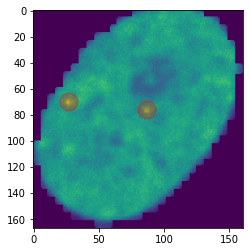

[[70.  27.   0.3]
 [76.  87.   0.3]]


In [21]:
# display image and found spots -- these coordinates (+ offset) can be used to look up precalculated z-position and radial position. 
plt.imshow(image)

fig = plt.gcf()
ax = fig.gca()

for spot in spots:
    circle = plt.Circle((spot[1], spot[0]), 7, color='r', alpha=0.3)
    ax.add_patch(circle)

plt.show()

print(spots)

In [ ]:
# use flood to find extent of spot and calculate center of mass
# this sets a tolerance as, essentially, half-maximum intensity: half the difference between the maximum intensity (spot center) and the background (75th percentile).

spot_positions = spots[0:,0:2].astype(int)

markers = numpy.zeros(numpy.shape(image)).astype(int)
for spot in spot_positions:
    marker = skimage.segmentation.flood(image, tuple(spot), tolerance=(image[spot[0],spot[1]] - background)/2)
    markers = marker + markers
    print(scipy.ndimage.center_of_mass(image, marker))


plt.imshow(markers)
plt.show()